# Predicting patient matches from incomplete data
### Tony Zhang and David Zhang

* * *

### 1) Introduction 

For this project, we decided to use an algorithm that employed levenshtein's algorithm to detect discrepencies between two patient fields and determine whether the patients are in the same group. With our modified algorithm, we were able to achieve 99.9% accuracy on the test data set, without hardcoding to any specific patients in the given data set. We also considered other algorithms, such as soundex tokens and metaphone, but given the time constraint and the fact that levenshtein was able to accurately predict a large majority of patient matches, we did not implement any additional algorithms and left that for future work.

#### Data Cleaning


#### Matching Algorithm


#### Accuracy

#### Conclusion

>*asdf

* * * 


In [3]:
import json
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import re

In [4]:
# load patients from csv file
def load_patients(path):
    file = pd.read_csv(path)
    return file

patients = load_patients("./PatientMatchingData.csv")
patients.head()

,GroupID,PatientID,Patient Acct #,First Name,MI,Last Name,Date of Birth,Sex,Current Street 1,Current Street 2,...,Current State,Current Zip Code,Previous First Name,Previous MI,Previous Last Name,Previous Street 1,Previous Street 2,Previous City,Previous State,Previous Zip Code
0,1,1,247028705-7,Sutton,J,Power,9/20/1945,Male,1858 Sullivan Parkway,NaN,...,California,93726.0,NaN,NaN,NaN,2 Erie Crossing,Apt 9,Mount Vernon,New York,10557.0
1,1,2,NaN,Suttin,James,Power,9/21/1945,Male,1859 Sullivan Parkway,#2,...,California,93726.0,NaN,NaN,NaN,2 Erie Crossing,Apartment # 9,Mount Vernon,New York,10557.0
2,1,3,247028705-7,Sutton,J,Power,9/20/1945,Male,1858 Sullivan Parkway,NaN,...,CA,93726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,NaN,Sutton,NaN,Power,9/20/1954,Male,1858 Sullivan Parkway,NaN,...,California,93726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,NaN,SUTTON,NaN,POWER,9/20/1954,Male,1858 SULLIVAN PKWAY,APT 2,...,California,93726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Levenshtein Distance Algorithm

def levenshtein(seq1, seq2):
    # if either is null, return 0
    if pd.isna(seq1) or pd.isna(seq2)or seq1 == 'nan' or seq2 == 'nan':
        return 0
    
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
#     print (matrix)
    return (matrix[size_x - 1, size_y - 1])

Data clean-up

In [6]:
# show columns and data type for each column
print(patients.columns)
print([type(x) for x in patients.columns])

Index(['GroupID', 'PatientID', 'Patient Acct #', 'First Name', 'MI',
       'Last Name', 'Date of Birth', 'Sex', 'Current Street 1',
       'Current Street 2', 'Current City', 'Current State', 'Current Zip Code',
       'Previous First Name', 'Previous MI', 'Previous Last Name',
       'Previous Street 1', 'Previous Street 2', 'Previous City',
       'Previous State', 'Previous Zip Code'],
      dtype='object')
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


In [31]:
# treat all columns (besides ID and account #'s) as alphabetic (ie string) for now
alphabeticCols = ['First Name', 'MI',
       'Last Name', 'Date of Birth', 'Sex', 'Current Street 1',
       'Current Street 2', 'Current City', 'Current State', 'Current Zip Code',
       'Previous First Name', 'Previous MI', 'Previous Last Name',
       'Previous Street 1', 'Previous Street 2', 'Previous City',
       'Previous State', 'Previous Zip Code']

patientsClean = patients.copy()


# make everything lowercase
for col in alphabeticCols:
    patientsClean.loc[:,col] = patientsClean.loc[:,col].astype(str).str.lower()
    
# make gender binary (0 for male 2 for female 1 for unknown) 1
# cleaning last and first name (removing digits, whitespace, and some special characters)
# cleaned current city by removing digits
for i in range(len(patientsClean)):
    patientsClean.loc[i, 'Last Name'] = re.sub('[\d\s]', '', patientsClean.loc[i,'Last Name'])
    patientsClean.loc[i, 'First Name'] = re.sub('[\d\s]', '', patientsClean.loc[i,'First Name'])
    patientsClean.loc[i, 'Sex'] = re.sub('[\d\s]', '', patientsClean.loc[i,'Sex'])
    patientsClean.loc[i, 'Sex'] = 0 if patientsClean.loc[i,'Sex'][0] == 'm' else 2 if patientsClean.loc[i,'Sex'][0] == 'f' else 1
    patientsClean.loc[i, 'Current City'] = re.sub('[\d]', '', patientsClean.loc[i, 'Current City'])
                                                  
patientsClean

,GroupID,PatientID,Patient Acct #,First Name,MI,Last Name,Date of Birth,Sex,Current Street 1,Current Street 2,...,Current State,Current Zip Code,Previous First Name,Previous MI,Previous Last Name,Previous Street 1,Previous Street 2,Previous City,Previous State,Previous Zip Code
0,1,1,247028705-7,sutton,j,power,9/20/1945,0,1858 sullivan parkway,nan,...,california,93726.0,nan,nan,nan,2 erie crossing,apt 9,mount vernon,new york,10557.0
1,1,2,NaN,suttin,james,power,9/21/1945,0,1859 sullivan parkway,#2,...,california,93726.0,nan,nan,nan,2 erie crossing,apartment # 9,mount vernon,new york,10557.0
2,1,3,247028705-7,sutton,j,power,9/20/1945,0,1858 sullivan parkway,nan,...,ca,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
3,1,4,NaN,sutton,nan,power,9/20/1954,0,1858 sullivan parkway,nan,...,california,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
4,1,5,NaN,sutton,nan,power,9/20/1954,0,1858 sullivan pkway,apt 2,...,california,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,61,197,NaN,bill,nan,smith,5/16/1972,0,16595 city view lane,nan,...,wa,98684.0,nan,nan,nan,nan,nan,nan,nan,nan
197,62,198,NaN,bill,nan,smith,5/16/1972,0,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
198,63,199,NaN,sarah,nan,field,3/17/2010,2,9850 kelso road,nan,...,wa,98626.0,nan,nan,nan,nan,nan,nan,nan,nan
199,64,200,NaN,sara,nan,field,3/17/2010,2,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [81]:
# verify if patient1 and patient2 are the same person
# need to determine optimal cutoffs (ie what levenshtein score is considered "different" enough to be 2 different people?)
def verify(patient1, patient2):
    numErrors = 0 # error considered as a field that is significantly different
    # consider first name
    compsMade = comparisons(patient1, patient2)
    if levenshtein(patient1['First Name'], patient2['First Name']) > 2:
        numErrors += 1
    # consider middle name
    if patient1['MI'] != 'nan' and patient2['MI'] != 'nan':
        if patient1['MI'][0] != patient2['MI'][0]:
            numErrors += 1
    # consider last name
    if levenshtein(patient1['Last Name'], patient2['Last Name']) > 2:
        numErrors += 1
    # consider DOB - more strict evaluation b/c less likely to mistype date of birth > 3 typos
    if levenshtein(patient1['Date of Birth'], patient2['Date of Birth']) > 3:
        # make sure there aren't any swapped character typos
        # TODO: swapped regex ?
        return False
    elif levenshtein(patient1['Date of Birth'], patient2['Date of Birth']) > 2:
        numErrors += 1
    # consider gender
    if abs(int(patient1['Sex']) - int(patient2['Sex'])) > 1:
        numErrors += 1
    # consider current street 1
    if levenshtein(patient1['Current Street 1'], patient2['Current Street 1']) > 3:
        numErrors += 1
    # consider current city
    if levenshtein(patient1['Current City'], patient2['Current City']) > 2:
        numErrors += 1
    # consider zip
    if levenshtein(patient1['Current Zip Code'], patient2['Current Zip Code']) > 2:
            numErrors += 1
    # consider previous city
    if levenshtein(patient1['Previous City'], patient2['Previous City']) > 2:
        numErrors += 1
    # consider zip
    if levenshtein(patient1['Previous Zip Code'], patient2['Previous Zip Code']) > 2:
            numErrors += 1
    if compsMade > 7:
        return numErrors <= 2
    return numErrors <= 1

In [82]:
# take into account number of comparisons made
def comparisons(patient1, patient2):
    compsMade = 0
    if patient1['First Name'] != 'nan' and patient2['First Name'] != 'nan':
        compsMade += 1
    if patient1['Last Name'] != 'nan' and patient2['Last Name'] != 'nan':
        compsMade += 1
    if patient1['Date of Birth'] != 'nan' and patient2['Date of Birth'] != 'nan':
        compsMade += 1
    if patient1['Sex'] != 'nan' and patient2['Sex'] != 'nan':
        compsMade += 1
    if patient1['Current Street 1'] != 'nan' and patient2['Current Street 1'] != 'nan':
        compsMade += 1
    if patient1['Current City'] != 'nan' and patient2['Current City'] != 'nan':
        compsMade += 1
    if patient1['Current Zip Code'] != 'nan' and patient2['Current Zip Code'] != 'nan':
        compsMade += 1
    if patient1['Previous City'] != 'nan' and patient2['Previous City'] != 'nan':
        compsMade += 1
    if patient1['Previous Zip Code'] != 'nan' and patient2['Previous Zip Code'] != 'nan':
        compsMade += 1
    return compsMade

In [83]:
# Evaluation function to test accuracy
total = 0
correct = 0
falsePos = 0
falseNeg = 0
for index, patient in patientsClean.iterrows():
    for index1, patient1 in patientsClean.iterrows():
        if(index1 > index):
            result = verify(patient, patient1)
            ID1 = patient['GroupID']
            ID2 = patient1['GroupID']
            actual = ID1 == ID2
            if result == actual:
                correct += 1
            elif result == True:
                print('false positive found between patients: ', patient['PatientID'], " and ", patient1['PatientID'])
                falsePos += 1
            elif result == False:
                print('false negative found between patients: ', patient['PatientID'], " and ", patient1['PatientID'])
                falseNeg += 1
            total += 1

print("correct: ", correct)
print("total: ", total)
print("false positives: ", falsePos)
print("false negatives: ", falseNeg)
print("accuracy: ", correct/total)
        

false negative found between patients:  10  and  13
false negative found between patients:  32  and  34
false negative found between patients:  33  and  34
false positive found between patients:  35  and  36
false negative found between patients:  52  and  53
false negative found between patients:  53  and  54
false negative found between patients:  53  and  55
false negative found between patients:  53  and  56
false negative found between patients:  111  and  113
false positive found between patients:  122  and  127
false positive found between patients:  123  and  127
false positive found between patients:  124  and  127
false positive found between patients:  125  and  127
false positive found between patients:  126  and  127
false negative found between patients:  180  and  181
false positive found between patients:  197  and  198
false positive found between patients:  199  and  200
false positive found between patients:  199  and  201
false positive found between patients:  200 

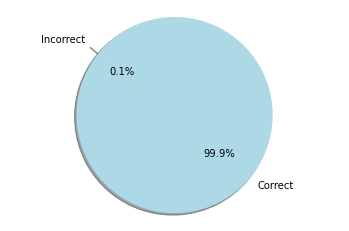

In [84]:
# Data to plot
labels =["Correct","Incorrect"]
sizes = [correct, total-correct]
colors = ["lightblue","whitesmoke"]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.show()

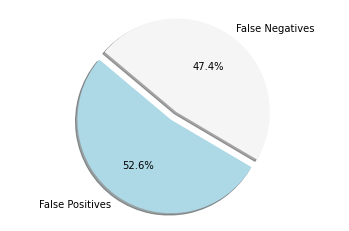

In [85]:
# Data to plot
labels =["False Positives","False Negatives"]
sizes = [falsePos, falseNeg]
colors = ["lightblue","whitesmoke"]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.show()